## Import all important libraries ##

In [1]:
import torch
from diffusers import DiffusionPipeline
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import peft
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## Model Definition ##

In [2]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
device = "mps"


pipe = DiffusionPipeline.from_pretrained(model_id, 
                                         variant = "fp16",
                                         torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Add LoRA weights ##

In [ ]:
pipe.load_lora_weights("AdamLucek/sdxl-base-1.0-oldbookillustrations-lora")

## Inject text prompt ##

In [ ]:

image_prompt =  "You will be responsible for managing the way your Direct Payments are spent, if you employ a Personal Assistant."


image = pipe(image_prompt, 
             height = 1024,
             width = 1024,
             guidance_scale= 6.0, 
             num_inference_steps=30).images[0]

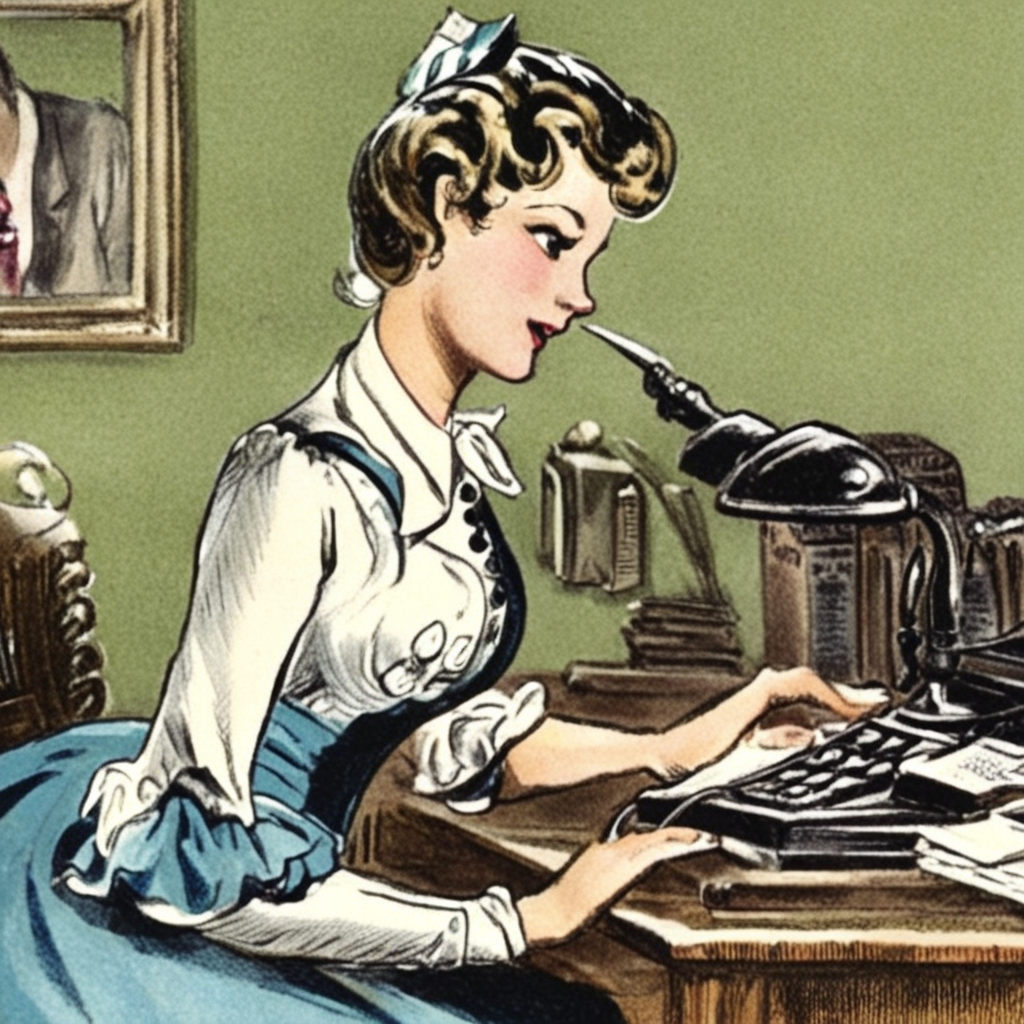

In [ ]:
image

In [16]:
image.save(f'{image_prompt}_new.png')

In [14]:
pipe.save_pretrained('./saved_image_model')

/opt/anaconda3/envs/text_summary/lib/python3.12/site-packages/transformers/integrations/peft.py:397: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


## Model Evaluation ##

In [54]:
# Hyperparameters definition

guidance_scales = [6.5, 7.0, 7.5]
num_inference_steps_options = [40, 50, 70]

In [55]:
# Cross validation parameters definition 
kf = KFold(n_splits=3) 
prompts = [
    "A calendar highlighting 10 working days",
    "You will be responsible for managing the way your Direct Payments are spent, if you employ a Personal Assistant.",
    "A futuristic cityscape with flying cars"
]

In [ ]:
best_model_dir = "./saved_image_model"

best_score = float('-inf')  # Higher is better for CLIP scores
best_config = None

# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# CLIP score to evaluate the image quality
def evaluate_image_quality(image: Image.Image, prompt: str) -> float:
    # Prepare the image and text inputs
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to(device)
   
    # Compute the CLIP score
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        clip_score = logits_per_image.item()
   
    return clip_score

# Cross-validation loop using evaluate_image_quality
for guidance_scale in guidance_scales:
    for num_inference_steps in num_inference_steps_options:
        fold_scores = []
        
        for train_index, test_index in kf.split(prompts):
            test_prompt = [prompts[i] for i in test_index][0]  # Just one prompt for simplicity
            
            # Generate the image
            with torch.inference_mode():
                image = pipe(test_prompt, 
                             height=256,
                             width=256,
                             guidance_scale=guidance_scale, 
                             num_inference_steps=num_inference_steps).images[0]
                
                # Evaluate the image quality using CLIP
                score = evaluate_image_quality(image, test_prompt)
                fold_scores.append(score)
        
        # Calculate average score across all folds
        avg_score = np.mean(fold_scores)
        print(f'Avg_Score: {avg_score}, guidance_scale: {guidance_scale}, num_inference_steps: {num_inference_steps}')
        # Save the best model configuration
        if avg_score > best_score:  # Since CLIP score is higher-the-better
            best_score = avg_score
            best_config = {
                "guidance_scale": guidance_scale,
                "num_inference_steps": num_inference_steps
            }
            
            # Save the current best model configuration
            pipe.save_pretrained(best_model_dir)
            
            print(f"New best model saved with guidance_scale={guidance_scale} and num_inference_steps={num_inference_steps}")
